<a href="https://colab.research.google.com/github/TeamHub2/Job_task/blob/main/Face_images_of_three_different_ethnic_groups_of_Asia_using_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I use Transfer Learning based approach which is Resnet50 model.
ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.It is a widely used ResNet model and we have explored ResNet50 architecture in depth.

In [ ]:
#Import different kinds of library
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [ ]:
#Load the dataset from my drive
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Job/Mini Dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
#Class name in my dataset
class_name=dataset.class_names
class_name

['East Asian', 'Indian', 'Southeast Asian']

In [ ]:
#Lenth of my Dataset
len(dataset)

94

In [ ]:
#image shape 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 1 2 1 1 0 1 2 0 2 2 0 2 2 0 0 2 0 0 2 2 2 1 1 1 2 1 2 0 2 1]


In [ ]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[ 61.         54.         48.       ]
  [ 50.4375     43.4375     37.4375   ]
  [ 39.0625     32.0625     26.0625   ]
  ...
  [ 60.1875     35.9375     29.625    ]
  [ 65.375      38.375      31.375    ]
  [ 67.         40.         33.       ]]

 [[ 56.9375     49.9375     43.9375   ]
  [ 48.35547    41.35547    35.35547  ]
  [ 40.23047    33.23047    27.230469 ]
  ...
  [ 58.61328    34.871094   28.558594 ]
  [ 62.58203    36.902344   29.902344 ]
  [ 66.1875     39.1875     32.1875   ]]

 [[ 47.0625     40.0625     34.0625   ]
  [ 42.847656   35.847656   29.847656 ]
  [ 40.15625    33.15625    27.15625  ]
  ...
  [ 57.347656   33.722656   27.410156 ]
  [ 60.17578    35.058594   28.058594 ]
  [ 62.5625     36.9375     29.9375   ]]

 ...

 [[ 54.4375     24.4375     14.4375   ]
  [ 47.429688   17.429688    7.4296875]
  [ 42.503906   13.191406    4.5664062]
  ...
  [180.6875    118.6875     79.6875   ]
  [180.        118.         79.       ]
  [180.        118.         79.       ]]

 [

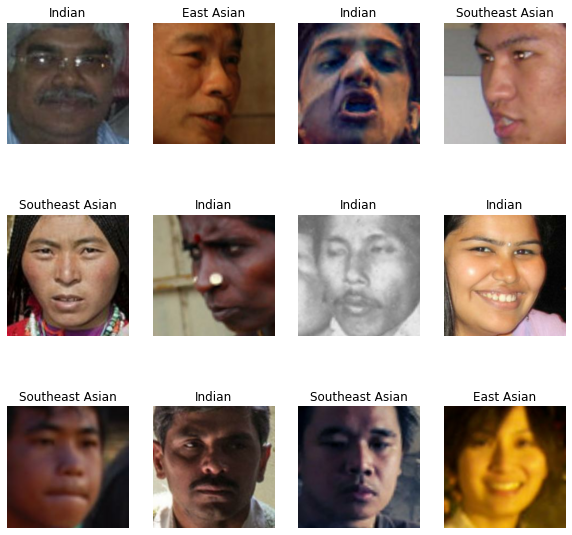

In [ ]:

plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[labels_batch[i]])
    plt.axis("off")
    
 

In [ ]:
len(dataset)

94

In [ ]:
#Train size is 80%
train_size = 0.8
len(dataset)*train_size

75.2

In [ ]:
train_ds = dataset.take(75)
len(train_ds)

75

In [ ]:
test_ds = dataset.skip(75)
len(test_ds)

19

In [ ]:
val_size=0.1
len(dataset)*val_size

9.4

In [ ]:
#Validation size 10%
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
#Test size 10%
test_ds = test_ds.skip(9)
len(test_ds)

10

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

75

In [ ]:
len(val_ds)

9

In [ ]:
len(test_ds)

10

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Resnet50 model
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
#Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
75/75 [==============================] - 21s 282ms/step - loss: 0.7671 - accuracy: 0.6526 - val_loss: 0.7724 - val_accuracy: 0.6736
Epoch 2/10
75/75 [==============================] - 21s 281ms/step - loss: 0.7041 - accuracy: 0.6906 - val_loss: 0.7619 - val_accuracy: 0.6736
Epoch 3/10
75/75 [==============================] - 21s 282ms/step - loss: 0.6560 - accuracy: 0.7149 - val_loss: 0.7238 - val_accuracy: 0.6458
Epoch 4/10
75/75 [==============================] - 21s 281ms/step - loss: 0.6339 - accuracy: 0.7182 - val_loss: 0.7059 - val_accuracy: 0.6910
Epoch 5/10
75/75 [==============================] - 21s 282ms/step - loss: 0.5716 - accuracy: 0.7588 - val_loss: 0.6749 - val_accuracy: 0.7118
Epoch 6/10
75/75 [==============================] - 21s 281ms/step - loss: 0.5438 - accuracy: 0.7822 - val_loss: 0.5993 - val_accuracy: 0.7674
Epoch 7/10
75/75 [==============================] - 21s 281ms/step - loss: 0.4702 - accuracy: 0.8144 - val_loss: 0.7189 - val_accuracy: 0.7014

In [ ]:
#Testing the model
scores = model.evaluate(test_ds)

10/10 [==============================] - 3s 252ms/step - loss: 0.5317 - accuracy: 0.8000


first image to predict
actual label: Indian
predicted label: Indian


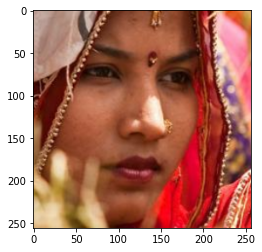

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

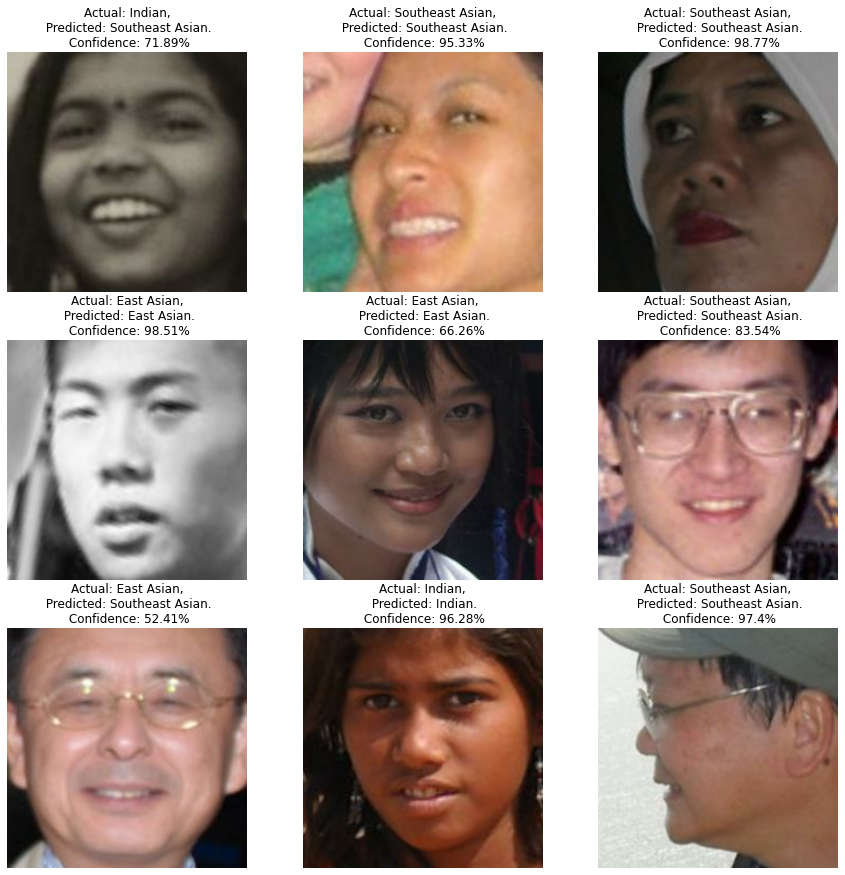

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")